# MNIST CNN in PyTorch (Binder-ready)

This notebook is a **convolutional neural network (CNN)** version of the earlier MLP demo,
kept Binder-friendly and classroom-ready. It adds convolution/pooling layers for better accuracy.


In [1]:

# --- Setup & Reproducibility --------------------------------------------------
import os, time, numpy as np
import torch

SEED = int(os.environ.get("SEED", 1234))
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("Device :", device)


PyTorch: 2.6.0
Device : cpu


In [2]:

# --- Imports ------------------------------------------------------------------
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:

# --- Data: MNIST --------------------------------------------------------------
# Normalize to standard MNIST mean/std for CNN training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

n_val = 10000
n_train = len(train_full) - n_val
train_ds, val_ds = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

batch_size = 128  # good default; Binder-safe with num_workers=0
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train/Val/Test sizes: 50000/10000/10000


In [4]:

# --- Model: A small CNN -------------------------------------------------------
# Architecture: (1x28x28) -> Conv(32, 3x3) -> ReLU -> Conv(64, 3x3) -> ReLU -> MaxPool(2)
#               -> Dropout(0.25) -> Flatten -> Linear(64*12*12, 128) -> ReLU
#               -> Dropout(0.5) -> Linear(128, 10)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 28 -> 14
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*14*14, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 10)        # raw logits
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total parameters: 1625866


In [5]:

# --- Training Loop ------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total, correct, running_loss = 0, 0, 0.0
    t0 = time.time()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    elapsed = time.time() - t0
    return running_loss/total, correct/total, elapsed

EPOCHS = 8  # CNN learns faster; 8 epochs is plenty for a demo
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_t = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_t = run_epoch(val_loader,   train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} ({tr_t:.1f}s) | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} ({va_t:.1f}s)")


Epoch  1/8 | train loss 0.2532 acc 0.9236 (91.1s) | val loss 0.0724 acc 0.9782 (3.4s)
Epoch  2/8 | train loss 0.0909 acc 0.9734 (55.5s) | val loss 0.0517 acc 0.9854 (3.3s)
Epoch  3/8 | train loss 0.0698 acc 0.9793 (52.3s) | val loss 0.0475 acc 0.9872 (3.2s)
Epoch  4/8 | train loss 0.0556 acc 0.9827 (51.7s) | val loss 0.0400 acc 0.9895 (3.3s)
Epoch  5/8 | train loss 0.0494 acc 0.9847 (52.7s) | val loss 0.0402 acc 0.9890 (3.2s)
Epoch  6/8 | train loss 0.0416 acc 0.9869 (51.6s) | val loss 0.0395 acc 0.9893 (3.2s)
Epoch  7/8 | train loss 0.0383 acc 0.9877 (52.5s) | val loss 0.0349 acc 0.9912 (3.7s)
Epoch  8/8 | train loss 0.0321 acc 0.9896 (53.8s) | val loss 0.0437 acc 0.9890 (3.2s)


In [6]:

# --- Test Set Evaluation ------------------------------------------------------
model.eval()
total, correct, running_loss = 0, 0, 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
test_loss = running_loss/total
test_acc = correct/total
print(f"\nTest loss {test_loss:.4f} | Test accuracy {test_acc:.4f}")



Test loss 0.0322 | Test accuracy 0.9901


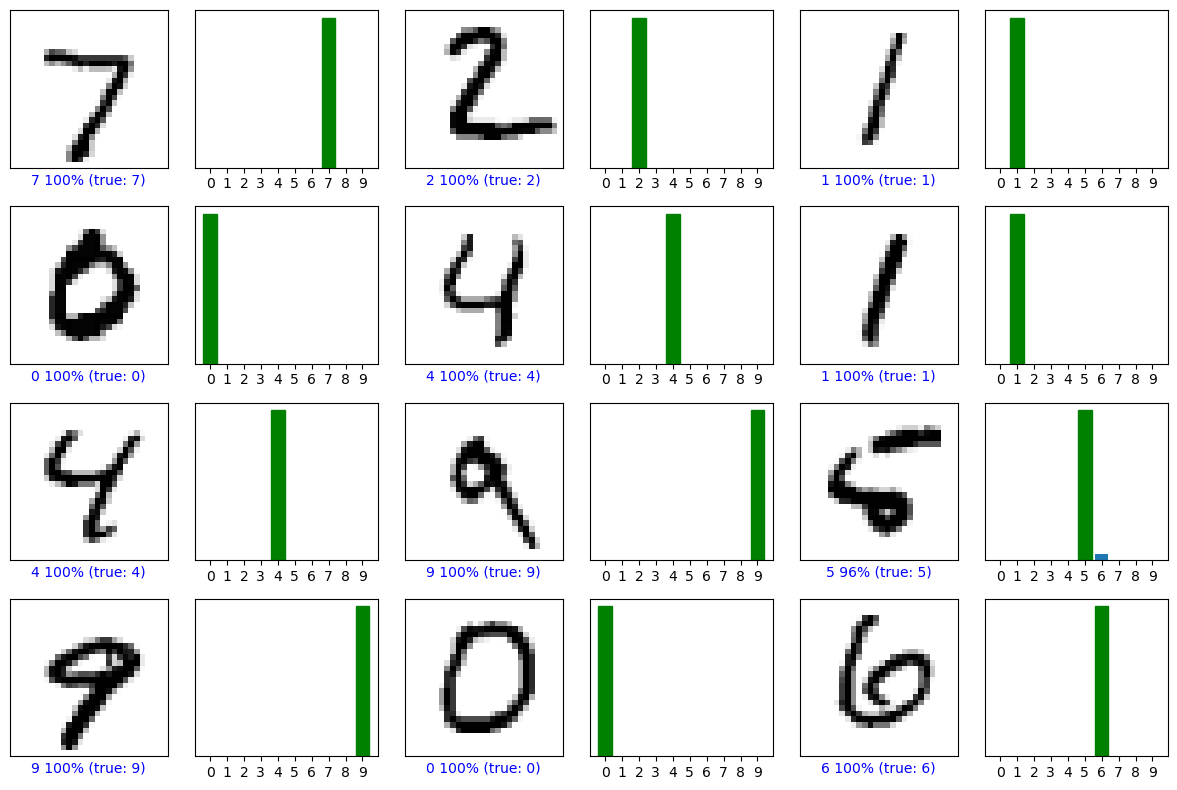

In [7]:

# --- Prediction & Visualization ----------------------------------------------
import numpy as np
softmax = nn.Softmax(dim=1)

# Inverse normalization for display
inv_mean, inv_std = 0.1307, 0.3081
def denorm(x):
    return (x * inv_std + inv_mean).clamp(0, 1)

def predict_probs(x_batch):
    model.eval()
    with torch.no_grad():
        return softmax(model(x_batch)).cpu().numpy()

def plot_image(predictions_array, true_label, img):
    import matplotlib.pyplot as plt
    predictions_array, true_label, img = predictions_array, int(true_label), img
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = int(np.argmax(predictions_array))
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f"{predicted_label} {100*np.max(predictions_array):2.0f}% (true: {true_label})", color=color)

def plot_value_array(predictions_array, true_label):
    import matplotlib.pyplot as plt
    predictions_array, true_label = predictions_array, int(true_label)
    plt.grid(False); plt.xticks(range(10)); plt.yticks([])
    bars = plt.bar(range(10), predictions_array)
    bars[np.argmax(predictions_array)].set_color('red')
    bars[true_label].set_color('green')

# Gallery
num_rows, num_cols = 4, 3
num_images = num_rows * num_cols
fig = plt.figure(figsize=(2*2*num_cols, 2*num_rows))

imgs, labels = [], []
for i in range(num_images):
    img, label = test_ds[i]
    imgs.append(img)
    labels.append(label)
xb = torch.stack(imgs).to(device)
probs = predict_probs(xb)

for i in range(num_images):
    img = denorm(imgs[i]).squeeze().cpu().numpy()  # de-normalize for nicer display
    label = labels[i]
    ax1 = plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(probs[i], label, img)
    ax2 = plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(probs[i], label)
plt.tight_layout(); plt.show()


## Notes
- The CNN uses **two conv layers (32→64)** with 3×3 kernels, **ReLU**, a **2×2 max-pool**, then two FC layers.
- We normalize MNIST to `(mean=0.1307, std=0.3081)` which helps training; images are **denormalized for display**.
- `EPOCHS=8` is chosen to keep Binder runs snappy while still achieving strong accuracy (>99% is typical).